In [1]:
import json
import numpy as np
import PIL.Image
import matplotlib.pyplot as plt
import cv2
from utils import *

In [4]:
video_path = '/media/kyrollosd/FAA/Cabin/rowL-2.mp4'

#seat detect
with open(f"{video_path}.json",'r') as f:
    ann = json.load(f)
    bbox_seat = []
    mask_seat = []
    for a in ann["shapes"]:
        if a['label'] == 'seat':
            im = np.zeros((ann['imageHeight'],ann['imageWidth']),dtype=bool)
            bbox = np.array(a['points']).astype(int).flatten()
            mask = img_b64_to_arr(a['mask'])
            im[bbox[1]:bbox[3]+1,bbox[0]:bbox[2]+1] = mask
            bbox_seat.append(bbox)
            mask_seat.append(im)
                    
    bbox_seat = np.stack(bbox_seat,axis=0)
    mask_seat = np.stack(mask_seat,axis=0)

video = cv2.VideoCapture(video_path)
fps = video.get(cv2.CAP_PROP_FPS)
nb_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
frame_interval = int(fps)*1

In [5]:
curr = int(video.get(cv2.CAP_PROP_POS_FRAMES))

while True:
    ret, frame = video.read()
    if not ret:
        break
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    masked = np.expand_dims(mask_seat[1],2)*frame
    bbox = bbox_seat[1]
    bbox_shape = [bbox[2]+1-bbox[0],bbox[3]+1-bbox[1]]
    max_dim = np.argmax(bbox_shape)
    min_dim = np.argmin(bbox_shape)
    exp = (bbox_shape[max_dim]-bbox_shape[min_dim])//2
    if max_dim == 1:
        newbbox = [exp,0,bbox_shape[min_dim]+exp,bbox_shape[max_dim]]
    else:
        newbbox = [0,exp,bbox_shape[max_dim],bbox_shape[min_dim]+exp]
    square = np.zeros((bbox_shape[max_dim],bbox_shape[max_dim],3),dtype=int)
    square[newbbox[1]:newbbox[3],newbbox[0]:newbbox[2]] = masked[bbox[1]:bbox[3]+1,bbox[0]:bbox[2]+1]
    curr += frame_interval
    video.set(cv2.CAP_PROP_POS_FRAMES,curr)
    cv2.imshow('img',cv2.resize(square[...,::-1].astype(np.uint8),(224,244)))
    k = cv2.waitKey(33)
    if k == -1:  # if no key was pressed, -1 is returned
        continue
    else:
        break
cv2.destroyWindow('img')
video.release()

IndexError: list index out of range

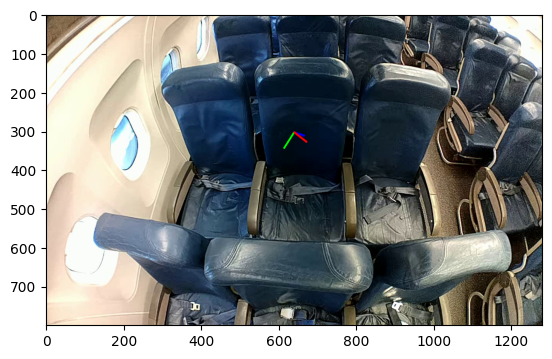

(-8.970979583175483, 55.80230640360455, 25.16822985504506)


In [121]:
from pose_estimation import HeadPoseEstimator
new_frame = frame.copy()
head_pose_estimator = HeadPoseEstimator(frame.shape[1],frame.shape[0])
head_pose = [np.array([[-0.35594221],
 [ 0.92671162],
 [ 0.47924738]]),np.array([-0.,-200.,2604.])]
head_pose_estimator.draw_axes(new_frame, head_pose)
plt.imshow(new_frame)
plt.show()
rmat, _ = cv2.Rodrigues(head_pose[0])
angles = cv2.RQDecomp3x3(rmat)[0]
print(angles)